In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

from sklearn.cluster import AffinityPropagation, DBSCAN, OPTICS, AgglomerativeClustering, AffinityPropagation, SpectralClustering, DBSCAN, OPTICS, Birch, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, make_scorer

from mpl_toolkits.mplot3d import Axes3D

<AxesSubplot:>

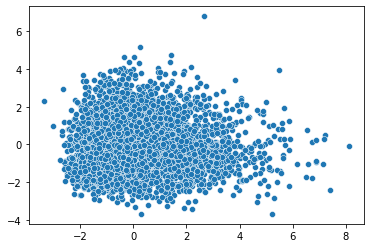

In [3]:
# Data Loading and Preparation

data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True) # Shuffle the dataframe rows
data = data[:6000]

# Fill out missing values with 0
data = data.fillna(0)

features = ['duration_ms', 'danceability', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

# Feature scaling
scaler = StandardScaler(with_mean=True, with_std=True).fit(data[features])
scaled_data = scaler.transform(data[features])

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)
data_2D = pca.transform(scaled_data)

# Visualizing 2D on scatter plot
sns.scatterplot(x=data_2D[:, 0], y=data_2D[:, 1], data=data_2D, legend=None)

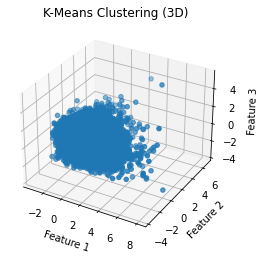

In [4]:
# Visualizing the data in 3D

pca_3D = PCA(n_components=3)
pca_3D.fit(scaled_data)
data_3D = pca_3D.transform(scaled_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_3D[:, 0], data_3D[:, 1], data_3D[:, 2], cmap='rainbow')
ax.set_title('K-Means Clustering (3D)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

In this repository, we are going to explore a group of different clustering algorithms offered by 'sklearn'. In general, there are two types of clustering methods: one is those that don't have a number of cluster parameters and the other that does.
https://scikit-learn.org/stable/modules/clustering.html

Models without K number of clusters as parameter:
- Affinity Propagation
- DBSCAN
- OPTICS

Models with K number of clusters as parameter:
- KMeans
- Birch
- Agglomerative
- Gaussian Mixture


We are going to score our models with three different clustering metrics:
- Silhouette Score:

 Measures the similarity of each sample to its own cluster (cohesion) compared to other clusters (separation).
 
 Values range from -1 to 1, with higher values indicating better cluster quality (well seperated and compact clusters).
 
- Davies-Bouldin Index:

Measures the average similarity between each cluster and the cluster that is most similar to it.

Lower values indicate better clustering solutions, with 0 being the best possible score.

- Calinski-Harabasz Index (Variance Ratio Criterion):

Evaluates the ratio of between-cluster variance to within-cluster variance.

Higher values indicate better-defined clusters.

## Models without K number of clusters as a parameter

* Affinity Propagation

https://python.plainenglish.io/the-mechanics-of-affinity-propagation-clustering-eb199cc7a7c2

Affinity Propagation is a clustering algorithm that identifies a set of exemplars among the data points and forms clusters around these exemplars. It automatically predicts the number of clusters based on the data. 

Exemplars are specific data points that serve as representatives or prototypes for each cluster. Essentially, an exemplar is a data point within a cluster that best summarizes or characterizes the other data points in that cluster.

In [5]:
# The two critical hyperparameters for Affinity Propagation are 'damping' and 'preference'.
# We are going to seach over the best damping value.

damping_values = [0.5, 0.6, 0.7, 0.8, 0.9]  # range of damping values to search over
preference_values = [-50, -15, 0, 1, 15, 50]  # range of preference values to search over

ap_best_davies_bouldin = float('inf')
best_damping = None
best_preference = None

for damping in damping_values:
    for preference in preference_values:
        ap = AffinityPropagation(damping=damping, preference=preference)
        ap.fit(scaled_data)
        labels = ap.labels_
        dbi_score = davies_bouldin_score(scaled_data, labels)

        # Use the Davies-Bouldin Index as the evaluation metric
        if dbi_score < ap_best_davies_bouldin:
            ap_best_davies_bouldin = dbi_score
            best_damping = damping
            best_preference = preference

print("Best Damping Value:", best_damping)
print("Best Davies-Bouldin Score:", ap_best_davies_bouldin)

# Rebuild the new model
best_ap = AffinityPropagation(damping=best_damping, preference=best_preference)

# Cluster labels for each data point
ap_labels = best_ap.labels_
# Cluster centers (exemplars)
ap_cluster_centers = scaled_data[best_ap.cluster_centers_indices_]

# Print cluster labels and cluster centers
print("Cluster Labels:", ap_labels)
print("Cluster Centers (Exemplars):")
print(ap_cluster_centers)

ValueError: Number of labels is 6000. Valid values are 2 to n_samples - 1 (inclusive)

The Affinity Propagation algorithm doesn't converge with our dataset, even while experiencing different hyperparameter values. Several reasons can contribute to it having difficulty converging including: 

    - a very large dataset which is the case of ours, since the computation of pairwise similarities can be computationally expensive.
    - sensibility to noise and outliers



* DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

https://en.wikipedia.org/wiki/DBSCAN

It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

Parameter Tuning: DBSCAN requires two main hyperparameters to be set:

    - Epsilon (eps): The radius that defines the neighborhood around each point.
    - Minimum Points (min_samples): The minimum number of data points required within the epsilon radius to consider a point as a core point (A core point must have at least a specified minimum number of data points within a certain distance and is density-reachable).

In [9]:
# I couldn't use sklearn's built in hyperparameter tuning method because I don't have ground-truth labels.

dbscan_param_dist = {
    'eps': np.linspace(0.1, 10, 10),
    'min_samples': [5, 10, 50, 100, 800, 1000]
}

dbscan_best_params = None
dbscan_best_silhouette_score = -1  

for _ in range(20):  # Perform 20 random searches 
    # Randomly sample parameters
    params = {
        'eps': np.random.choice(dbscan_param_dist['eps']),
        'min_samples': np.random.choice(dbscan_param_dist['min_samples'])
    }

    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    dbscan.fit(scaled_data)

    # Get cluster labels (-1 represents noise points)
    dbscan_labels = dbscan.labels_
    print(dbscan_labels)

    # Calculate the silhouette score
    score = silhouette_score(scaled_data, dbscan_labels)

    # Update best score and parameters if a better score is found
    if score > dbscan_best_silhouette_score:
        dbscan_best_silhouette_score = score
        dbscan_best_params = params

print("Best Parameters:", dbscan_best_params)
print("Best Silhouette Score:", dbscan_best_silhouette_score)

[-1 -1 -1 ... -1 -1 -1]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Similarily to Affinity Propagation, DBSCAN doesn't converge well. I tried to run it both using scaled data and data in 2D. Maybe I am missing something.

* OPTICS

https://en.wikipedia.org/wiki/OPTICS_algorithm

Ordering points to identify the clustering structure (OPTICS) is an algorithm for finding density-based clusters in spatial data. Its basic idea is similar to DBSCAN, but it addresses one of DBSCAN's major weaknesses: the problem of detecting meaningful clusters in data of varying density. To do so, the points of the database are (linearly) ordered such that spatially closest points become neighbors in the ordering. Additionally, a special distance is stored for each point that represents the density that must be accepted for a cluster so that both points belong to the same cluster. 

Parameter Tuning: OPTICS requires two main hyperparameters to be set:

    - 'min_samples': represents the minimum number of samples in a neighborhood for a data point to be considered as a core point. 
    - 'xi': is a parameter that controls the relative importance of the reachability distance in the OPTICS algorithm. It affects the ordering of data points in the reachability plot. A smaller xi value gives more weight to the reachability distance, resulting in a tighter clustering structure. A larger xi value gives less weight to reachability and may produce more extended clusters.

In [16]:
optics_param_dist = {
    'xi': [0.05, 0.1, 0.2, 0.5, 1], 
    'min_samples': [5, 10, 50, 100, 800, 1000]
}

optics_best_params = None
optics_best_silhouette_score = -1  

for _ in range(20):
    params = {
        'xi': np.random.choice(optics_param_dist['xi']),
        'min_samples': np.random.choice(optics_param_dist['min_samples'])
    }

    optics  = OPTICS(cluster_method='xi', xi=params['xi'], min_samples=params['min_samples'])
    optics.fit(scaled_data)

    optics_labels = optics.labels_

    score = silhouette_score(scaled_data, optics_labels)

    if score > optics_best_silhouette_score:
        optics_best_silhouette_score = score
        optics_best_params = params

print("Best Parameters:", optics_best_params)
print("Best Silhouette Score:", optics_best_silhouette_score)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [9]:
# Let's try fitting the models without specifying any hyperparameters. We'll plot the results instead of calculating the evaluation metrics since we keep getting errors.

without_k_models = [('Affinity Propagation', AffinityPropagation), ('DBSCAN', DBSCAN), ('OPTICS', OPTICS)]

def evaluation_without_k(without_k_models, data):
    
    # silhouette = []
    # davies = []
    # calinski = []
    # dict_scores = {}
    
    cols = 1
    rows = len(without_k_models)
    fig = plt.figure(figsize=(10, 10))
    gs = plt.GridSpec(rows, cols)
    
    
    for idx, model in enumerate(without_k_models):
        
        clstr = model[1]().fit(data)
        labels = clstr.labels_
        y = clstr.fit_predict(data)
        
        #silhouette.append(silhouette_score(data, labels))
        #davies.append(davies_bouldin_score(data, labels))
        #calinski.append(calinski_harabasz_score(data, labels))
        
        #dict_scores[model[0]] = {'davies':davies, 'calinski':calinski}
        
        
        # Plotting setup: plotting the clusters in 2D
        
        i = 0
        j = idx
        
        plt.subplot(gs[j,i])
        plt.scatter(data_2D[:, 0], data_2D[:, 1], c=y, cmap='rainbow')
        plt.title('Clustering with '+ model[0])
        plt.show()

    
    #print(dict_scores)
    

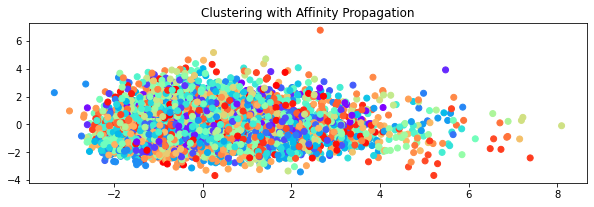

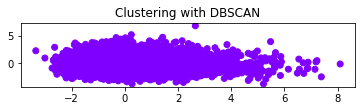

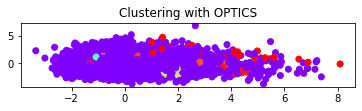

In [10]:
evaluation_without_k(without_k_models, scaled_data)

Models without K number of clusters as parameter are not promising since they either cluster the whole dataset as one cluster or do not converge. Below, we are going to explore the other type of models.

## Models with K number of clusters as parameter


* KMeans

https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

The elbow point is not entirely clear from the graph above, but we can identify it as that when k is around 15.

The clusters are not quite visible from the visualization, so we need to use other metrics to evaluate the quality of clustering which we will focus on at later in the notebook, when comparing between KMeans and the other algorithms.

* Birch

https://en.wikipedia.org/wiki/BIRCH

BIRCH (balanced iterative reducing and clustering using hierarchies) is an unsupervised data mining algorithm used to perform hierarchical clustering over particularly large data-sets. An advantage of BIRCH is its ability to incrementally and dynamically cluster incoming, multi-dimensional metric data points in an attempt to produce the best quality clustering for a given set of resources (memory and time constraints). In most cases, BIRCH only requires a single scan of the database.

* Agglomerative

https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2

Agglomerative Clustering is a member of the Hierarchical Clustering family.

Agglomerative Clustering or bottom-up clustering essentially started from an individual cluster (each data point is considered as an individual cluster, also called leaf), then every cluster calculates their distance with each other. The two clusters with the shortest distance with each other would merge creating what we called node. Newly formed clusters once again calculating the member of their cluster distance with another cluster outside of their cluster. The process is repeated until all the data points assigned to one cluster called root. The result is a tree-based representation of the objects called dendrogram.

* Gaussian Mixture

https://behesht.medium.com/unsupervised-learning-clustering-using-gaussian-mixture-model-gmm-c788b280932b

GMM (Gaussian Mixture Model) is a probabilistic clustering method that assigns a probability distribution to each cluster, allowing for more flexible and accurate clustering than other methods. GMM can model complex cluster shapes and can handle overlapping clusters. GMM is also useful for density estimation, which involves estimating the probability distribution of a set of data points.

In [56]:
# We are going to evaluate all the models above using through evalution metrics: Silhouette Score, Davies-Bouldin and Calinski-Harabasz. 
#Then, we are going to select the best clustering algorithm.

models = [('KMeans', KMeans), ('Birch', Birch), ('Agglomerative', AgglomerativeClustering), 
          ('Gaussian Mixture', GaussianMixture)]

dict_scores = {} # this dictionary will store the evaluation metrics of each model

# The following function evaluates the above models given a range of k number of clusters.
def evaluation(data, max_k):
    
    cluster_size = range(2, max_k+1) # the number of clusters will range from 2 to max_k
    
    cols = 3
    rows = len(models)
    y_size = 5*rows
    fig = plt.figure(figsize=(18,y_size))
    gs = plt.GridSpec(rows, cols)
    
    for idx, model in enumerate(models):
        silhouette = []
        davies = []
        calinski = []
        
        for k in cluster_size:
            if model[0] == 'KMeans':
                clstr = model[1](n_clusters=k, random_state=0).fit(data)
                labels = clstr.labels_
                
            elif model[0]=='Gaussian Mixture':
                clstr = model[1](n_components=k).fit(data)
                labels = clstr.predict(data)
                
            elif model[0] in ('Agglomerative', 'Birch'):
                clstr = model[1](n_clusters=k).fit(data)
                labels = clstr.labels_
   
            silhouette.append(silhouette_score(data, labels))
            davies.append(davies_bouldin_score(data, labels))
            calinski.append(calinski_harabasz_score(data, labels))
            
        dict_scores[model[0]] = {'silhouette':silhouette, 'davies':davies, 'calinski':calinski}
                   
        i = 0
        j = idx
        
        plt.subplot(gs[j,i])
        plt.plot(cluster_size, silhouette, label='silhouette score')
        plt.title(model[0]+' Silhouette Score', fontsize=15)
        plt.xlabel("k")
        plt.ylabel("Score")
        
        plt.subplot(gs[j,i+1])
        plt.plot(cluster_size, davies, label='davies score')
        plt.title(model[0]+' Davies-Bouldin Score')
        plt.xlabel("k")
        
        plt.subplot(gs[j,i+2])
        plt.plot(cluster_size, calinski, label='calinski score')
        plt.title(model[0]+' Calinski-Harabasz score')
        plt.xlabel("k")
    
    plt.show()    

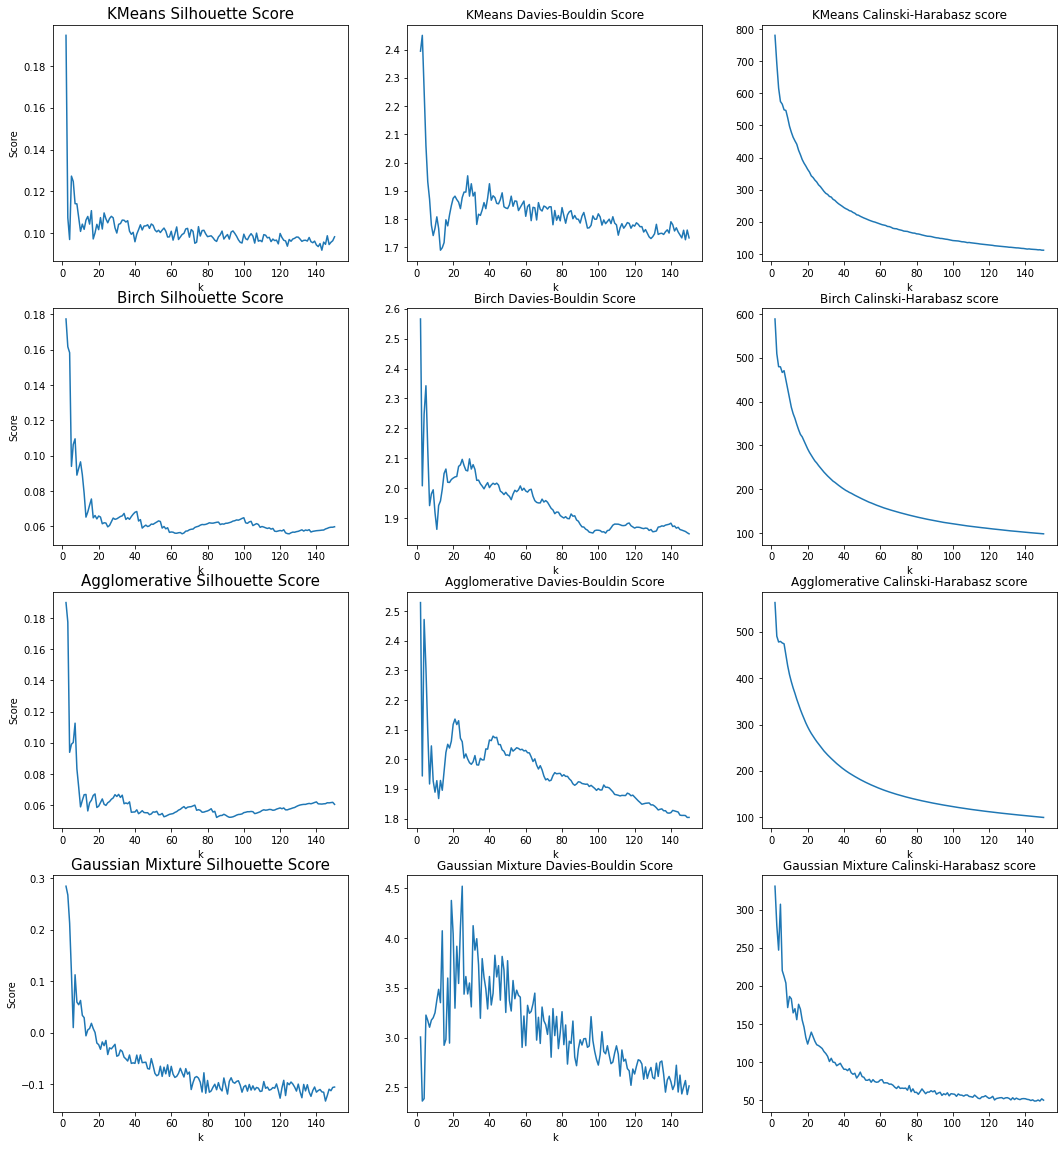

In [57]:
# Note: running this function takes a long time
evaluation(scaled_data, max_k = 150)

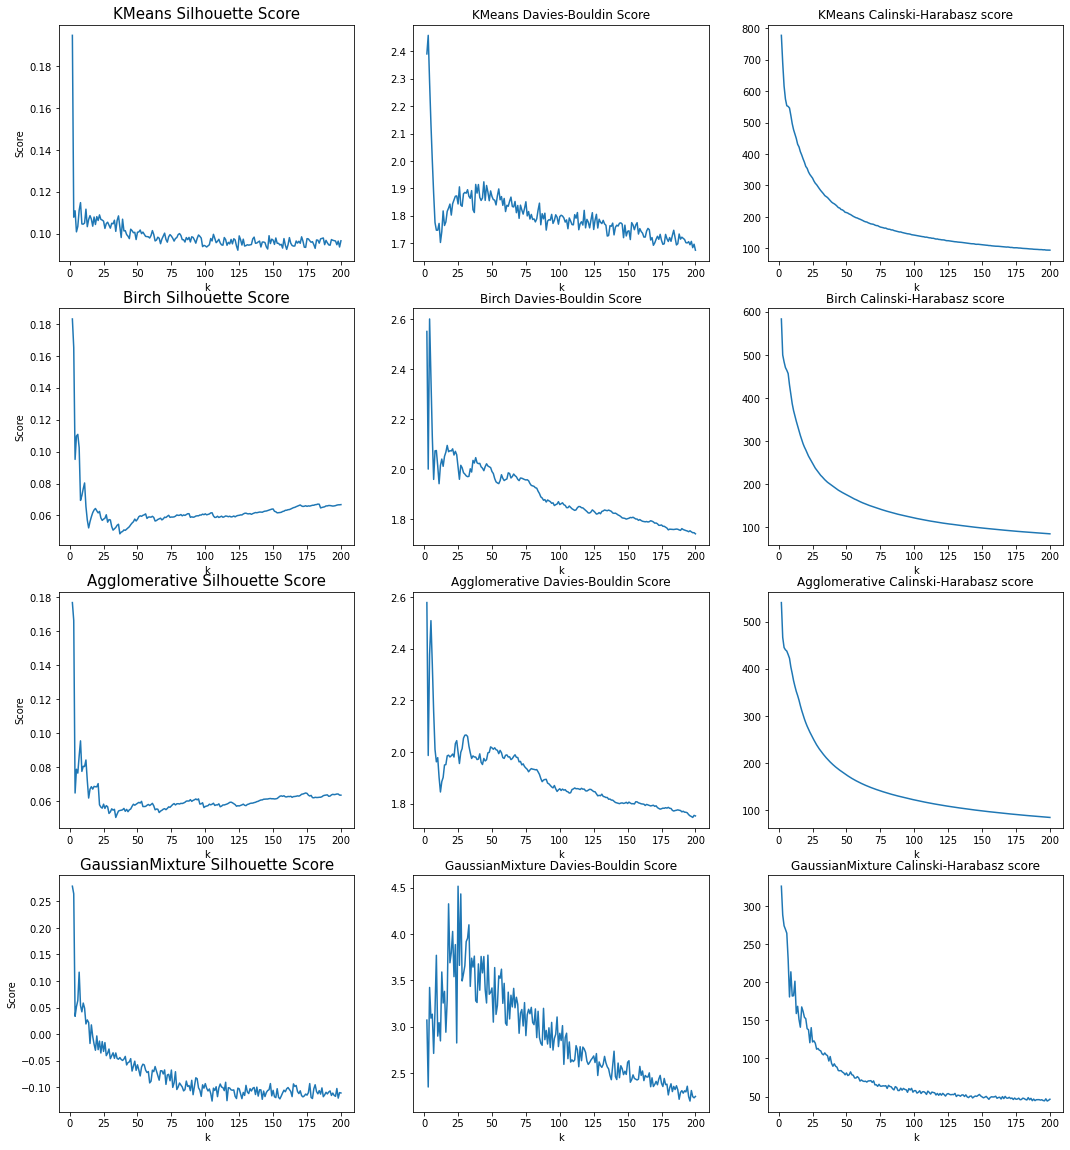

In [5]:
# Note: running this function takes a long time
evaluation(scaled_data, max_k = 200)

From the graphs above, Davies-Boulding seems to be the best way to score our data, the lowest the score the better the clustering. But we should be careful of choosing the right k value. The right one would be the point when the score is the minimum and then increases.

In [93]:
# The following dataframe contains the evaluation scores of the models built with max_iter = 150

df_scores = pd.DataFrame(dict_scores)
df_scores

,KMeans,Birch,Agglomerative,Gaussian Mixture
silhouette,"[0.1947579449606511, 0.1073026539688314, 0.096...","[0.1774304506378143, 0.16169069477110062, 0.15...","[0.18990497065409256, 0.17739230627241392, 0.0...","[0.2841915337587695, 0.26714184942021274, 0.21..."
davies,"[2.3942120179264337, 2.4502156019675687, 2.255...","[2.5655755808892033, 2.0084169491359636, 2.248...","[2.528636889346367, 1.9435506810920284, 2.4716...","[3.005541380925725, 2.3624868209887917, 2.3872..."
calinski,"[780.0583366139706, 692.0953289078439, 615.920...","[588.5440899992143, 509.2995729827999, 479.652...","[563.0929099825033, 490.6004629401658, 478.022...","[330.8540144117653, 279.2765952235211, 246.911..."


In [131]:
# Extract the best K for each model based on Davies-Bouldin score, that is the lowest one for k in [2, 50].
# This range is chosen given the observation of the graphs above (for max_k = 150).

best_KMeans_K = np.asarray(dict_scores['KMeans']['davies'])[2:50].argsort()[0]+2
best_Birch_K = np.asarray(dict_scores['Birch']['davies']).argsort()[2:50].argsort()[0]+2
best_Aglomerative_K = np.asarray(dict_scores['Agglomerative']['davies'])[2:50].argsort()[0]+2
best_GaussianMixture_K = np.asarray(dict_scores['Gaussian Mixture']['davies'])[2:50].argsort()[0]+2

print('best_KMeans_K :', best_KMeans_K)
print('best_Birch_K :', best_Birch_K)
print('best_Aglomerative_K :', best_Aglomerative_K)
print('best_GaussianMixture_K :', best_GaussianMixture_K)


best_KMeans_K : 11
best_Birch_K : 24
best_Aglomerative_K : 10
best_GaussianMixture_K : 2


In [124]:
best_Birch_K

Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=Birch(n_clusters=24))))))))))))

In [133]:
# Davies score for each optimal model 

print('KMeans Davies Score: ', np.asarray(dict_scores['KMeans']['davies'])[best_KMeans_K])
print('Birch Davies Score: ', np.asarray(dict_scores['Birch']['davies'])[best_Birch_K])
print('Agglomerative Davies Score: ', np.asarray(dict_scores['Agglomerative']['davies'])[best_Aglomerative_K])
print('Gaussian Mixture Davies Score: ', np.asarray(dict_scores['Gaussian Mixture']['davies'])[best_GaussianMixture_K])


KMeans Davies Score:  1.689589901210743
Birch Davies Score:  2.076127283238973
Agglomerative Davies Score:  1.8674594798769
Gaussian Mixture Davies Score:  2.3872306744402305


We observe that KMeans has the least score.

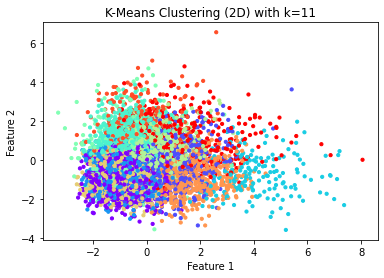

In [97]:
# Visualize the new clusters with the optimal k values for each model

best_KMeans = KMeans(n_clusters = best_KMeans_K)
KMeans_labels = best_KMeans.fit_predict(scaled_data)

# Plot

plt.scatter(data_2D[:, 0], data_2D[:, 1], c=KMeans_labels, cmap='rainbow', s=10)
plt.title('K-Means Clustering (2D) with k=11')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

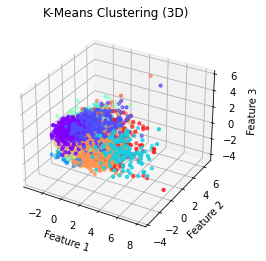

In [98]:
# Plot the clusters in 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_3D[:, 0], data_3D[:, 1], data_3D[:, 2], c=KMeans_labels, cmap='rainbow', s=10)
ax.set_title('K-Means Clustering (3D)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

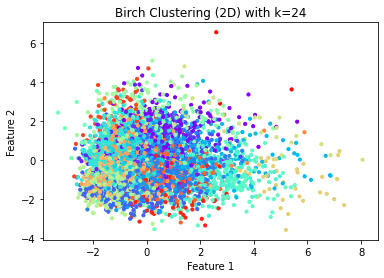

In [126]:
best_Birch = Birch(n_clusters = best_Birch_K)
Birch_labels = best_Birch.fit_predict(scaled_data)

# Plot
fig = plt.figure()

plt.scatter(data_2D[:, 0], data_2D[:, 1], c=Birch_labels, cmap='rainbow', s=10)
plt.title('Birch Clustering (2D) with k=24')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

Text(0.5, 0, 'Feature 3')

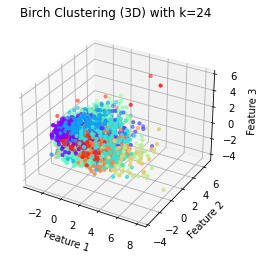

In [112]:
# Plot the clusters in 3D
fig = plt.figure()

ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(data_3D[:, 0], data_3D[:, 1], data_3D[:, 2], c=Birch_labels, cmap='rainbow', s=10)
ax2.set_title('Birch Clustering (3D) with k=24')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')

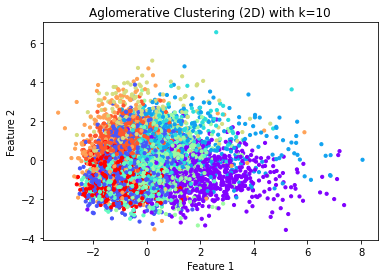

In [132]:
best_Aglomerative = AgglomerativeClustering(n_clusters = best_Aglomerative_K)
Aglo_labels = best_Aglomerative.fit_predict(scaled_data)

# Plot
fig = plt.figure()

plt.scatter(data_2D[:, 0], data_2D[:, 1], c=Aglo_labels, cmap='rainbow', s=10)
plt.title('Aglomerative Clustering (2D) with k=10')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

Text(0.5, 0, 'Feature 3')

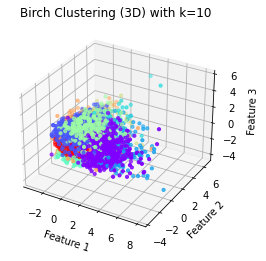

In [115]:
# Plot the clusters in 3D
fig = plt.figure()

ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(data_3D[:, 0], data_3D[:, 1], data_3D[:, 2], c=Aglo_labels, cmap='rainbow', s=10)
ax2.set_title('Birch Clustering (3D) with k=10')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')

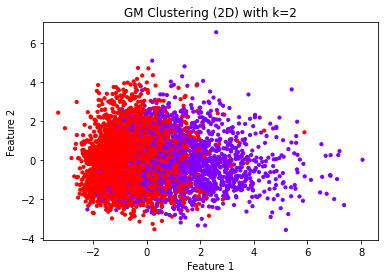

In [129]:
best_GaussianMixture = Birch(n_clusters = best_GaussianMixture_K)
GM_labels = best_GaussianMixture.fit_predict(scaled_data)

# Plot
fig = plt.figure()

plt.scatter(data_2D[:, 0], data_2D[:, 1], c=GM_labels, cmap='rainbow', s=10)
plt.title('GM Clustering (2D) with k=2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

Text(0.5, 0, 'Feature 3')

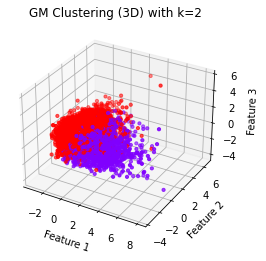

In [117]:
# Plot the clusters in 3D
fig = plt.figure()

ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(data_3D[:, 0], data_3D[:, 1], data_3D[:, 2], c=GM_labels, cmap='rainbow', s=10)
ax2.set_title('GM Clustering (3D) with k=2')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Feature 3')

Given the Davies Scores of the models and the visualization of their optimal representations, we conlude that KMeans is the best model for our problem. 

Additional Analysis for KMeans:

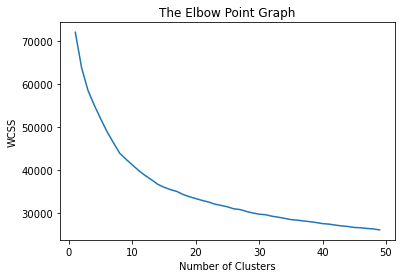

In [24]:
# Finding the optimal number of clusters K using the elbow method

wcss = [] # within-cluster sum of squares (WCSS) which represents the sum of squared distances of samples to their closest cluster center
# the least WCSS is the more compact the clustering is

for i in range(1,50):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,50), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

This method is not valuable in determing the optimal k since the elbow point is not clear.

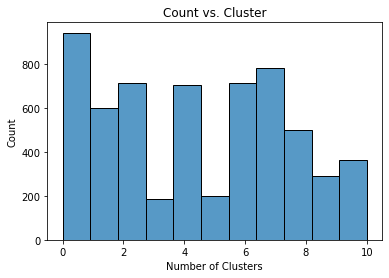

In [120]:
# Plot the number of number of data points in each cluster for KMeans
sns.histplot(KMeans_labels, bins=11)
plt.xlabel('Number of Clusters')
plt.title('Count vs. Cluster')
plt.ylabel('Count')
plt.show()